In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Upload Dataset From Kaggle

In [ ]:
from google.colab import files
files.upload()         # expire any previous token(s) and upload recreated token


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"christiansada1","key":"15162c34eda998d0fa83ad4553966d32"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d anamibnjafar0/flamevision

 99% 3.66G/3.68G [00:47<00:00, 86.8MB/s]
100% 3.68G/3.68G [00:47<00:00, 83.6MB/s]


In [ ]:
!unzip flamevision.zip

Streaming output truncated to the last 5000 lines.
  inflating: FlameVision  A new dataset for wildfire classification and detection using aerial imagery/FlameVision/Detection/train/annotations/fire-917-_png.rf.516c6c60adec17122a7bbb12975c017f.xml  
  inflating: FlameVision  A new dataset for wildfire classification and detection using aerial imagery/FlameVision/Detection/train/annotations/fire-920-_png.rf.ae159b53f6aceaf4025f7be80523207e.xml  
  inflating: FlameVision  A new dataset for wildfire classification and detection using aerial imagery/FlameVision/Detection/train/annotations/fire-921-_png.rf.a8e07f0490c4840544b94216a29107b5.xml  
  inflating: FlameVision  A new dataset for wildfire classification and detection using aerial imagery/FlameVision/Detection/train/annotations/fire-922-_png.rf.9ef20d9933ac8b346a6a79038df087e7.xml  
  inflating: FlameVision  A new dataset for wildfire classification and detection using aerial imagery/FlameVision/Detection/train/annotations/fire-923-_

# GPU

In [ ]:
path= '/content/FlameVision  A new dataset for wildfire classification and detection using aerial imagery'

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # for the first GPU

In [ ]:
import tensorflow as tf

if tf.test.is_gpu_available():
    print("GPU is available")
else:
    print("GPU is not available")


GPU is available


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


# The Dataset
The FlameVision dataset is a comprehensive aerial image dataset designed specifically for detecting and classifying wildfires. It consists of a total of 8600 high-resolution images, with 5000 images depicting fire and the remaining 3600 images depicting non-fire scenes. The images are provided in PNG format for classification tasks and JPG format for detection tasks. The dataset is organized into two primary folders, one for detection and the other for classification, with further subdivisions into train, validation, and test sets for each folder.

## Preprocessing

visualizing image with fire

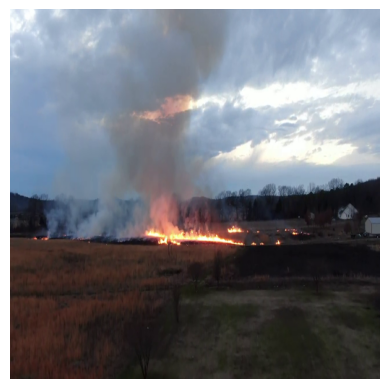

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
img = mpimg.imread(path+'/FlameVision/Classification/train/fire/fire (1321).png')

# Display the image
plt.imshow(img)
plt.axis('off')  # to turn off the axis values
plt.show()

visualizing an image without fire

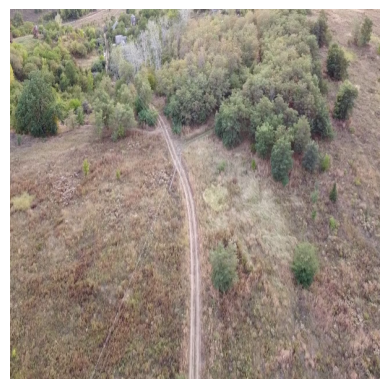

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
img = mpimg.imread(path+'/FlameVision/Classification/train/nofire/nofire (1024).png')

# Display the image
plt.imshow(img)
plt.axis('off')  # to turn off the axis values
plt.show()

visualizing an i,age with smoke

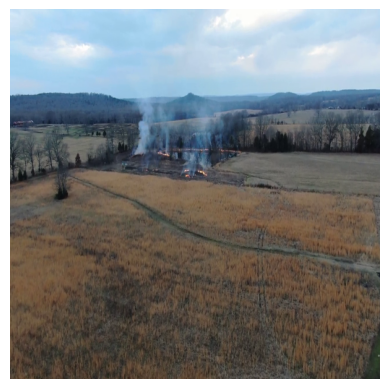

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
img = mpimg.imread(path+'/FlameVision/Classification/train/fire/fire (1001).png')

# Display the image
plt.imshow(img)
plt.axis('off')  # to turn off the axis values
plt.show()

Real-world images can come with various distortions. By introducing controlled distortions during training (e.g., shear, zoom and horizontal fliping), we prepare the model for similar variations it might encounter in real-world applications. To ensure robustness and increased generalization of the model,the images are sheared by a factor of 0.2 and zoomed by a factor of 0.2. The images are further resized to 64x64 in order to reduce the training time

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(path+'/FlameVision/Classification/train/',
                                            target_size=(64, 64),
                                            batch_size=32,
                                            classes= ['fire', 'nofire'],
                                            class_mode='binary')

test_set = test_datagen.flow_from_directory(path+'/FlameVision/Classification/test/',
                                            target_size=(64, 64),
                                            batch_size=32,
                                            classes= ['fire', 'nofire'],
                                            class_mode='binary')

val_set = val_datagen.flow_from_directory(path+'/FlameVision/Classification/valid/',
                                            target_size=(64, 64),
                                            batch_size=32,
                                            classes= ['fire', 'nofire'],
                                            class_mode='binary')


Found 6800 images belonging to 2 classes.
Found 900 images belonging to 2 classes.
Found 900 images belonging to 2 classes.


Getting the number of classes in train and test set, we notice that there is a fair level of balance between the two classes (fire an nofire) in n the training set

In [ ]:
# Get class indices
class_indices = training_set.class_indices

# Count number of samples in each class
fire_count = sum(training_set.labels == class_indices['fire'])
nofire_count = sum(training_set.labels == class_indices['nofire'])

print(f"Number of 'fire' samples: {fire_count}")
print(f"Number of 'nofire' samples: {nofire_count}")


Number of 'fire' samples: 3600
Number of 'nofire' samples: 3200


In [ ]:
# Get class indices
class_indices = test_set.class_indices

# Count number of samples in each class
fire_count = sum(test_set.labels == class_indices['fire'])
nofire_count = sum(test_set.labels == class_indices['nofire'])

print(f"Number of 'fire' samples: {fire_count}")
print(f"Number of 'nofire' samples: {nofire_count}")


Number of 'fire' samples: 700
Number of 'nofire' samples: 200


In [ ]:
# Get class indices
class_indices = val_set.class_indices

# Count number of samples in each class
fire_count = sum(val_set.labels == class_indices['fire'])
nofire_count = sum(val_set.labels == class_indices['nofire'])

print(f"Number of 'fire' samples: {fire_count}")
print(f"Number of 'nofire' samples: {nofire_count}")

Number of 'fire' samples: 700
Number of 'nofire' samples: 200


# ANN

A neural network, designed for binary classification of 64x64  resized color fire images. the network begins with a Flatten layer, which reshapes the input images into a 1D vector. Following this are two dense layers with 128 and 64 neurons, respectively, both using the ReLU activation function. The output layer consists of a single neuron with a sigmoid activation, producing a probability for classification. The model is compiled with the Adam optimizer, using binary crossentropy as its loss function, and tracks accuracy during training.


![Artificial Neural Network](https://miro.medium.com/v2/resize:fit:700/1*Gh5PS4R_A5drl5ebd_gNrg@2x.png)

In [ ]:

model = Sequential()
model.add(Flatten(input_shape=(64, 64, 3)))  # Flatten the 64x64x3 input image
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

the model was trained with 10 epochs of 6800 images

In [ ]:
history= model.fit(training_set, epochs=10, validation_data=val_set)

Epoch 1/10
213/213 [==============================] - 62s 283ms/step - loss: 0.4694 - accuracy: 0.7916 - val_loss: 0.5784 - val_accuracy: 0.6656
Epoch 2/10
213/213 [==============================] - 61s 285ms/step - loss: 0.3921 - accuracy: 0.8268 - val_loss: 0.2488 - val_accuracy: 0.9467
Epoch 3/10
213/213 [==============================] - 61s 287ms/step - loss: 0.3522 - accuracy: 0.8329 - val_loss: 0.3592 - val_accuracy: 0.8433
Epoch 4/10
213/213 [==============================] - 60s 284ms/step - loss: 0.3250 - accuracy: 0.8544 - val_loss: 0.3935 - val_accuracy: 0.9200
Epoch 5/10
213/213 [==============================] - 61s 288ms/step - loss: 0.2998 - accuracy: 0.8638 - val_loss: 0.6065 - val_accuracy: 0.7133
Epoch 6/10
213/213 [==============================] - 62s 292ms/step - loss: 0.2763 - accuracy: 0.8769 - val_loss: 0.6128 - val_accuracy: 0.7444
Epoch 7/10
213/213 [==============================] - 60s 281ms/step - loss: 0.2714 - accuracy: 0.8760 - val_loss: 0.5270 - val_ac

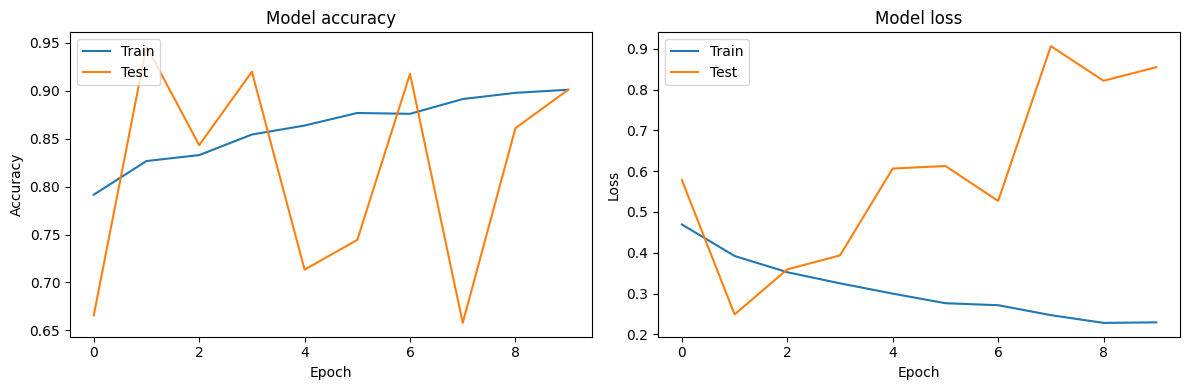

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
loss, accuracy = model.evaluate(test_set)
print(f"Accuracy: {accuracy * 100:.2f}%")

29/29 [==============================] - 10s 333ms/step - loss: 0.3496 - accuracy: 0.8989
Accuracy: 89.89%


In [ ]:
# Predict probabilities
probabilities = model.predict(test_set)

# Convert probabilities to binary predictions (0 or 1)
predictions = (probabilities > 0.5).astype(int).flatten()

29/29 [==============================] - 8s 266ms/step


In [ ]:
true_labels = test_set.classes

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predictions, labels=[1, 0])
# The `labels` argument is used to set the order of labels in the matrix
# (1: positive class, 0: negative class)

TP = cm[0, 0]
FN = cm[0, 1]
FP = cm[1, 0]
TN = cm[1, 1]

print(f"True Positive: {TP}")
print(f"False Negative: {FN}")
print(f"False Positive: {FP}")
print(f"True Negative: {TN}")

True Positive: 27
False Negative: 173
False Positive: 124
True Negative: 576


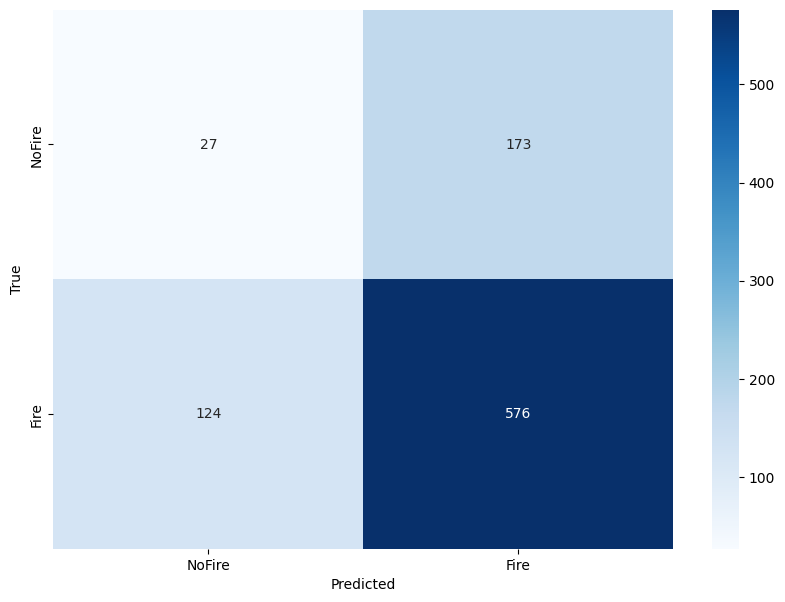

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['NoFire', 'Fire']

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# CNN

The convolutional neural network was designed for binary classification of 64x64 resized color images. The network begins with a convolutional layer of 32 filters and a 3x3 kernel size, followed by a max-pooling layer with a pool size of 2x2. A second convolutional layer with the same specifications is added next, followed again by a 2x2 max-pooling layer. After these convolutional operations, the network introduces a Flatten layer to reshape the output into a 1D vector. This is followed by a dense layer with 128 neurons using the ReLU activation function. The output layer of the network consists of a single neuron with a sigmoid activation, outputting a probability for classification. The model utilizes the Adam optimizer and binary crossentropy as its loss function while also tracking accuracy during training.

![CNN](https://www.codespeedy.com/wp-content/uploads/2019/05/convolutional-layers-of-an-image-Deep-learning-Machine-learning.jpg)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()

# First convolution layer and pooling
model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolution layer and pooling
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening the layers
model.add(Flatten())

# Adding a fully connected layer
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))  # Output layer

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history= model.fit(training_set, epochs=10, validation_data=val_set)

Epoch 1/10
213/213 [==============================] - 89s 381ms/step - loss: 0.3737 - accuracy: 0.8438 - val_loss: 0.1956 - val_accuracy: 0.9644
Epoch 2/10
213/213 [==============================] - 63s 294ms/step - loss: 0.2141 - accuracy: 0.9201 - val_loss: 0.1617 - val_accuracy: 0.9478
Epoch 3/10
213/213 [==============================] - 61s 288ms/step - loss: 0.1413 - accuracy: 0.9474 - val_loss: 0.2716 - val_accuracy: 0.9356
Epoch 4/10
213/213 [==============================] - 62s 289ms/step - loss: 0.0872 - accuracy: 0.9700 - val_loss: 0.5340 - val_accuracy: 0.8889
Epoch 5/10
213/213 [==============================] - 60s 283ms/step - loss: 0.0595 - accuracy: 0.9784 - val_loss: 0.1053 - val_accuracy: 0.9589
Epoch 6/10
213/213 [==============================] - 61s 285ms/step - loss: 0.0586 - accuracy: 0.9809 - val_loss: 1.2583 - val_accuracy: 0.5233
Epoch 7/10
213/213 [==============================] - 61s 285ms/step - loss: 0.0506 - accuracy: 0.9835 - val_loss: 0.3022 - val_ac

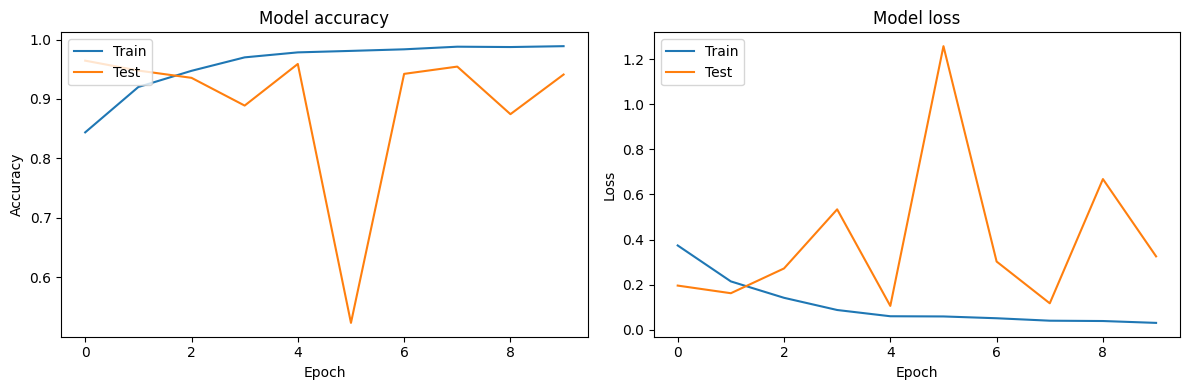

In [ ]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
loss, accuracy = model.evaluate(test_set)
print(f"Accuracy: {accuracy * 100:.2f}%")

29/29 [==============================] - 7s 228ms/step - loss: 0.1226 - accuracy: 0.9722
Accuracy: 97.22%


In [ ]:
import numpy as np

# Predict probabilities
probabilities = model.predict(test_set)

# Convert probabilities to binary predictions (0 or 1)
predictions = (probabilities > 0.5).astype(int).flatten()

29/29 [==============================] - 7s 234ms/step


In [ ]:
true_labels = test_set.classes

cm = confusion_matrix(true_labels, predictions, labels=[1, 0])
# The `labels` argument is used to set the order of labels in the matrix
# (1: positive class, 0: negative class)

TP = cm[0, 0]
FN = cm[0, 1]
FP = cm[1, 0]
TN = cm[1, 1]

print(f"True Positive: {TP}")
print(f"False Negative: {FN}")
print(f"False Positive: {FP}")
print(f"True Negative: {TN}")

True Positive: 44
False Negative: 156
False Positive: 159
True Negative: 541


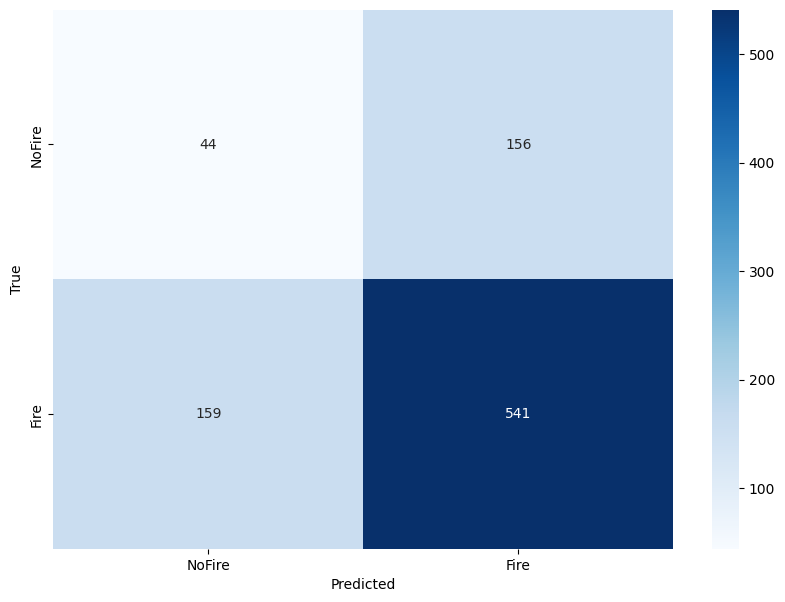

In [ ]:
import seaborn as sns

labels = ['NoFire', 'Fire']

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Transfer Learning with VGG16

The architecture of the VGG16 model, pre-trained on the ImageNet dataset, for binary classification of 64x64 color images. Initially, the VGG16 model is loaded without its top (fully connected) layers and its weights from the ImageNet training. All the layers of this pre-trained VGG16 model are then frozen, ensuring they won't be updated during subsequent training. Following the VGG16 base, the network employs a Flatten layer to reshape its output into a 1D vector. This is succeeded by a dense layer of 256 neurons with a ReLU activation function. The final output layer comprises a single neuron with a sigmoid activation function, determining the probability for classification. The model is compiled using the Adam optimizer, with binary crossentropy as its loss function, and accuracy as the performance metric during training.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications.vgg16 import VGG16

# Load pre-trained VGG16 model + higher level layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
history= model.fit(training_set, epochs=5, validation_data=test_set)

Epoch 1/5
213/213 [==============================] - 79s 353ms/step - loss: 0.1901 - accuracy: 0.9287 - val_loss: 0.1289 - val_accuracy: 0.9433
Epoch 2/5
213/213 [==============================] - 63s 298ms/step - loss: 0.0808 - accuracy: 0.9716 - val_loss: 0.0773 - val_accuracy: 0.9622
Epoch 3/5
213/213 [==============================] - 63s 295ms/step - loss: 0.0472 - accuracy: 0.9847 - val_loss: 0.0878 - val_accuracy: 0.9633
Epoch 4/5
213/213 [==============================] - 64s 301ms/step - loss: 0.0304 - accuracy: 0.9918 - val_loss: 0.1067 - val_accuracy: 0.9689
Epoch 5/5
213/213 [==============================] - 65s 304ms/step - loss: 0.0339 - accuracy: 0.9871 - val_loss: 0.1542 - val_accuracy: 0.9656


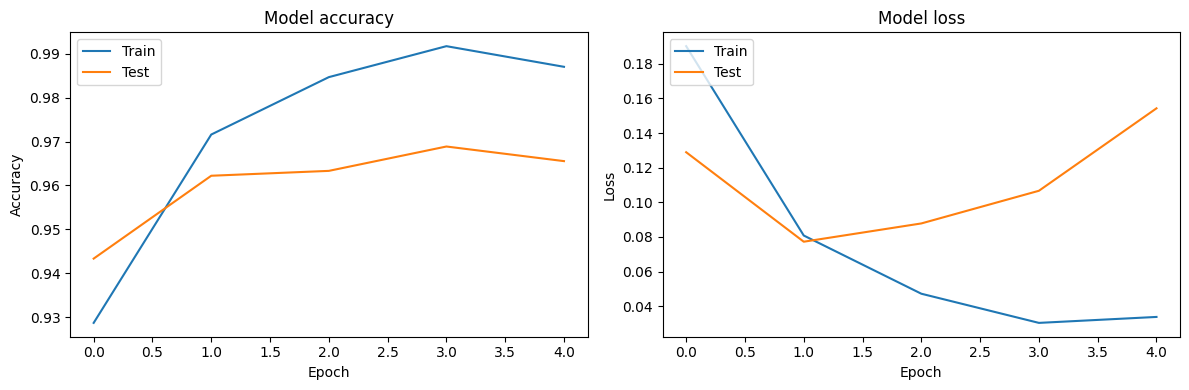

In [ ]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
loss, accuracy = model.evaluate(test_set)
print(f"Accuracy: {accuracy * 100:.2f}%")

29/29 [==============================] - 7s 243ms/step - loss: 0.1542 - accuracy: 0.9656
Accuracy: 96.56%


In [ ]:
# Predict probabilities
probabilities = model.predict(test_set)

# Convert probabilities to binary predictions (0 or 1)
predictions = (probabilities > 0.5).astype(int).flatten()

29/29 [==============================] - 12s 425ms/step


In [ ]:
true_labels = test_set.classes

cm = confusion_matrix(true_labels, predictions, labels=[1, 0])
# The `labels` argument is used to set the order of labels in the matrix
# (1: positive class, 0: negative class)

TP = cm[0, 0]
FN = cm[0, 1]
FP = cm[1, 0]
TN = cm[1, 1]

print(f"True Positive: {TP}")
print(f"False Negative: {FN}")
print(f"False Positive: {FP}")
print(f"True Negative: {TN}")

True Positive: 48
False Negative: 152
False Positive: 183
True Negative: 517


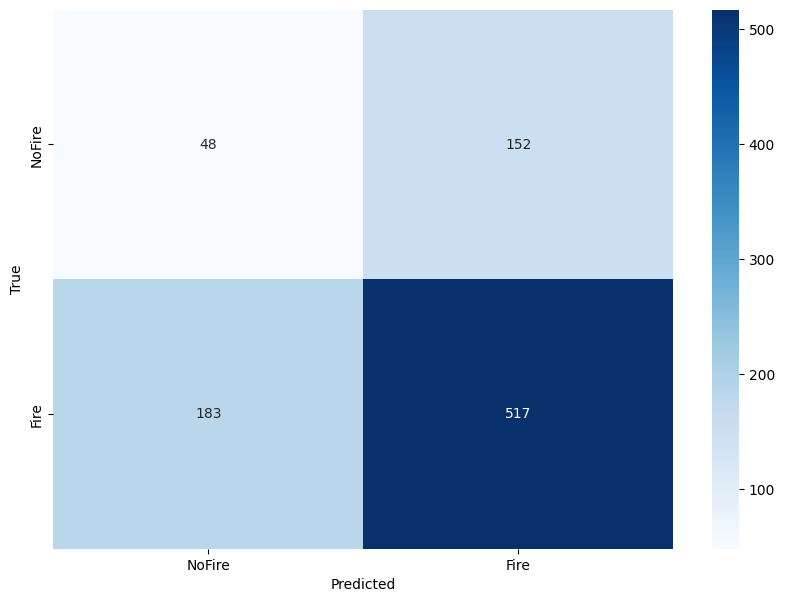

In [ ]:
import seaborn as sns

labels = ['NoFire', 'Fire']

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()